In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Imputer
import re
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from scipy.stats import skew
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("Beer Train Data Set.csv")
test_data = pd.read_csv("Beer test Data Set.csv")
test = test_data

In [3]:
train.head()

,ABV,Brewing Company,Food Paring,Glassware Used,Beer Name,Ratings,Style Name,Cellar Temperature,Serving Temperature,Score
0,6.5,8929,"(Curried,Thai)Cheese(pepperyMontereyPepperJack...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",15121,22,AmericanIPA,40-45,45-50,3.28
1,5.5,13187,"(PanAsian)Cheese(earthyCamembert,Fontina,nutty...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",59817,1,AmericanPaleAle(APA),35-40,40-45,3.52
2,8.1,6834,"Meat(Pork,Poultry)","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",32669,3,IrishRedAle,35-40,40-45,4.01
3,NaN,11688,"(Indian,LatinAmerican,PanAsian)General(Aperitif)","PintGlass(orBecker,Nonic,Tumbler),PilsenerGlas...",130798,0,AmericanMaltLiquor,35-40,35-40,0.00
4,6.0,10417,"Meat(Poultry,Fish,Shellfish)",PilsenerGlass(orPokal),124087,1,EuroPaleLager,35-40,40-45,2.73


In [4]:
train.isnull().sum()

ABV                    15130
Brewing Company            0
Food Paring                0
Glassware Used             0
Beer Name                  0
Ratings                    0
Style Name                 0
Cellar Temperature      6781
Serving Temperature      193
Score                      0
dtype: int64

In [5]:
test.isnull().sum()

ABV                     1664
Brewing Company            0
Food Paring                0
Glassware Used             0
Beer Name                  0
Ratings                    0
Style Name                 0
Cellar Temperature       755
Serving Temperature       21
Score                  20628
dtype: int64

In [6]:
train.dtypes

ABV                    float64
Brewing Company          int64
Food Paring             object
Glassware Used          object
Beer Name                int64
Ratings                 object
Style Name              object
Cellar Temperature      object
Serving Temperature     object
Score                  float64
dtype: object

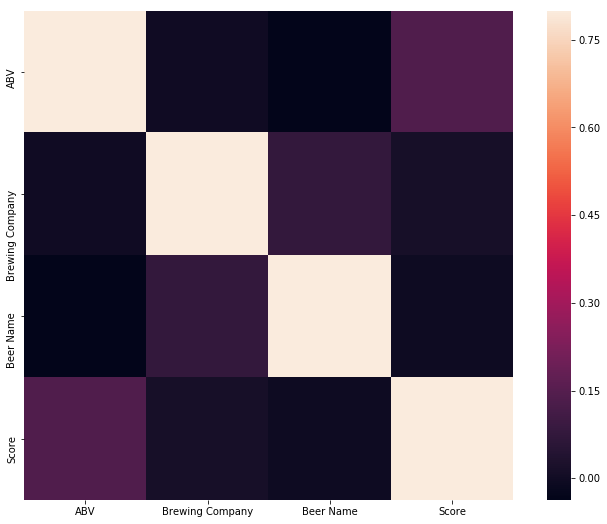

In [7]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

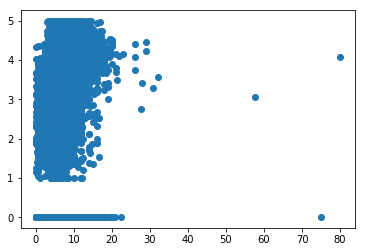

In [8]:
plt.scatter(x= train['ABV'],y=train['Score'])

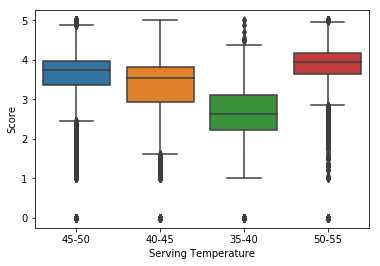

In [9]:
sns.boxplot(x= train['Serving Temperature'],y=train['Score'])

C:\Users\NITIN\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\NITIN\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


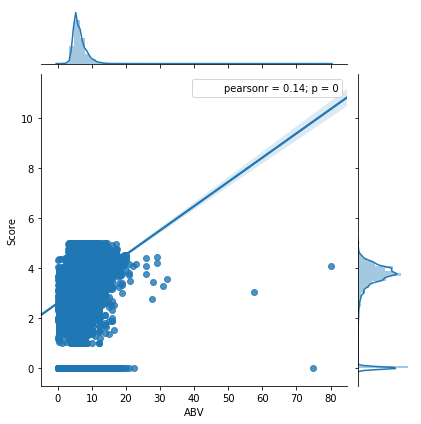

In [10]:
sns.jointplot(x= train['ABV'],y=train['Score'], kind='reg')

In [11]:
train[train['ABV'] >50]

# Seems these three style names has incorrect ABV as per online records

,ABV,Brewing Company,Food Paring,Glassware Used,Beer Name,Ratings,Style Name,Cellar Temperature,Serving Temperature,Score
918,57.5,10864,"(German)Cheese(butteryBrie,Gouda,Havarti,Swiss...","Flute,Snifter,OversizedWineGlass",130997,4,Eisbock,40-45,50-55,3.06
64234,75.0,5250,"(Curried,Thai)Cheese(pepperyMontereyPepperJack...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",25625,0,AmericanIPA,40-45,45-50,0.00
153616,80.0,8687,"(Barbecue)Cheese(butteryBrie,Gouda,Havarti,Swi...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",41017,2,AmericanPorter,40-45,45-50,4.08


In [12]:
train = train.drop(train[(train['ABV']>=25)].index).reset_index(drop=True)

In [13]:
train[train['ABV'] >25]
# Seems these three style names has incorrect ABV as per online records

,ABV,Brewing Company,Food Paring,Glassware Used,Beer Name,Ratings,Style Name,Cellar Temperature,Serving Temperature,Score


### Filling Missing Values

In [14]:
def fillServTemp(dataset,feature):
    print(dataset[feature].unique())
    value = dataset[['Beer Name',feature]]
    styleNameNulltemperature = value[value[feature].isnull()]
    # print(styleNameNulltemperature['Style Name'].unique()) # Kvass
    dataset[feature].fillna('45-50',inplace =True)

In [34]:
def fillCellerTemp(dataset,feature):
    value = dataset[['Style Name',feature]]
    styleNameNulltemperature = value[value[feature].isnull()]
    print(styleNameNulltemperature['Style Name'].unique()) # Kvass
    
fillCellerTemp(train,'Cellar Temperature')

['EnglishBitter' 'EnglishPorter' 'SmokedBeer' 'HerbedSpicedBeer'
 'EuroDarkLager' 'Kvass' 'Braggot']
[nan]


In [104]:
train.isnull().sum()

ABV                    15130
Brewing Company            0
Food Paring                0
Glassware Used             0
Beer Name                  0
Ratings                    0
Style Name                 0
Cellar Temperature         0
Serving Temperature        0
Score                      0
dtype: int64

## Modelling

### Import Libraries

In [30]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [31]:
#Validation function
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train)
    rmse= 1/(1 + np.exp(-np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv = kf))))
    return(rmse)

In [38]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.5, random_state=1))
score = 1 - rmsle_cv(lasso)
print(score.mean())

0.20489344349049268


In [ ]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.05, l1_ratio=.9, random_state=3))
score = 1- rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [37]:
GBoost = GradientBoostingRegressor(learning_rate=0.1)
score = 1- rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.4100 (0.0008)



In [35]:
model_lgb = lgb.LGBMRegressor(objective='regression')
score = 1- rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


LGBM score: 0.4129 (0.0007)



In [ ]:
def rmsle(y, y_pred):
    
    return np.sqrt(mean_squared_error(y, y_pred))
ENet.fit(train, y_train)
lgb_train_pred = ENet.predict(train)
lgb_pred = ENet.predict(test)
#print(rmsle(y_train, lgb_train_pred))

In [52]:
old_min = min(lgb_pred)
old_max = max(lgb_pred)
print(min(lgb_pred),max(lgb_pred))
lgb_pred = 5*(lgb_pred-old_min)/(old_max-old_min)

print(min(lgb_pred),max(lgb_pred))
#for i in lgb_pred:
#    new_value = ( (old_value - old_min) / (old_max - old_min) ) * (new_max - new_min) + new_min

2.36371280042 7.6748531507
0.0 5.0


In [ ]:
test_data["Score"] = lgb_pred

In [54]:
test_data.head()

,ABV,Brewing Company,Food Paring,Glassware Used,Beer Name,Ratings,Style Name,Cellar Temperature,Serving Temperature,Score
0,6.2,8803,"(Curried,Thai)Cheese(pepperyMontereyPepperJack...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",34558,3,AmericanIPA,40-45,45-50,0.914049
1,5.3,8558,"(Barbecue)Cheese(butteryBrie,Gouda,Havarti,Swi...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",86826,20,AmericanPorter,40-45,45-50,0.821235
2,7.0,7519,"Cheese(earthyCamembert,Fontina)General(Aperitif)","Snifter,Tulip,OversizedWineGlass",17051,0,BelgianDarkAle,45-50,45-50,0.878686
3,5.2,9852,"(LatinAmerican,German)Meat(Pork,Poultry)","Flute,PilsenerGlass(orPokal),Mug(orSeidel,Stein)",49156,2,ViennaLager,35-40,40-45,0.335156
4,8.1,8991,"(Barbecue)Cheese(butteryBrie,Gouda,Havarti,Swi...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",162723,5,AmericanPorter,40-45,45-50,0.928383


In [55]:
writer = pd.ExcelWriter('test_2.xlsx')
test_data.to_excel(writer,'Perfect-Beer')
writer.save()

In [46]:
min(lgb_pred)

2.3637128004159145